In [30]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
import matplotlib.patches as patches
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, '../code')
from network import *
from model_loader_func import load_multi_scale_denoisers_RF, load_BF_CNN_RF
from dataloader_func import load_CelebA_dataset, load_CelebA_HQ_dataset,prep_celeba
from quality_metrics_func import calc_psnr_range,batch_ave_psnr_torch
from wavelet_func import multi_scale_denoising, multi_scale_identity_denoising,multi_scale_decompose
from linear_approx import *
from plotting_func import plot_single_im,plot_all_coeffs, show_im_set
from algorithm_inv_prob import *

%matplotlib inline

In [31]:
print(torch.__version__)

1.13.1


In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Load denoisers

In [33]:
base_path= '/mnt/home/zkadkhodaie/ceph/multi_scale_synthesis/denoisers'
training_data_name='celebA_160x160_gray'
training_noise='noise_range_0to255'

denoisers_5x5 = load_multi_scale_denoisers_RF(base_path, training_data_name, training_noise, RF_low=40, RF=5, J=2)
denoisers_9x9 = load_multi_scale_denoisers_RF(base_path, training_data_name, training_noise, RF_low=40, RF=9, J=2)
denoisers_13x13 = load_multi_scale_denoisers_RF(base_path, training_data_name, training_noise, RF_low=40, RF=13, J=2)
denoisers_23x23 = load_multi_scale_denoisers_RF(base_path, training_data_name, training_noise, RF_low=40, RF=23, J=2)
denoisers_43x43 = load_multi_scale_denoisers_RF(base_path, training_data_name, training_noise, RF_low=40, RF=43, J=2)

In [34]:
print(denoisers_5x5.keys())
print(denoisers_5x5['low'].training )

dict_keys(['low', 0, 1])
False


In [35]:
training_data_name='celebA_160x160_gray'
training_noise='noise_range_0to255'     

flat_denoiser_5x5 =   load_BF_CNN_RF(base_path, training_data_name, training_noise, RF=5)
flat_denoiser_9x9 = load_BF_CNN_RF(base_path, training_data_name, training_noise, RF=9)
flat_denoiser_13x13 = load_BF_CNN_RF(base_path, training_data_name, training_noise, RF=13)
flat_denoiser_23x23 = load_BF_CNN_RF(base_path, training_data_name, training_noise, RF=23)
flat_denoiser_43x43 = load_BF_CNN_RF(base_path, training_data_name, training_noise, RF=43)


### Load images 

In [7]:
train_folder_path = '/mnt/home/zkadkhodaie/ceph/datasets/img_align_celeba/train/img_align_celeba/'
test_folder_path = '/mnt/home/zkadkhodaie/ceph/datasets/img_align_celeba/test/'
all_images= load_CelebA_dataset( train_folder_path, test_folder_path, s=1, n=100)
train_im, test_im = prep_celeba(all_images, k=None, mean_zero=False)
test_im = test_im.to(device)
train_im = train_im.to(device)
test_im.shape


torch.Size([100, 1, 160, 160])

# Denoising 

In [8]:
### calculate denoising psnr for flat denoisers 
denoising_range = torch.logspace(0.5,2.8,10)
flat_psnr_5 = calc_psnr_range(test_im, denoising_range, flat_denoiser_5x5)
flat_psnr_9 = calc_psnr_range(test_im, denoising_range, flat_denoiser_9x9)
flat_psnr_13 = calc_psnr_range(test_im, denoising_range, flat_denoiser_13x13)
flat_psnr_23 = calc_psnr_range(test_im, denoising_range, flat_denoiser_23x23)
flat_psnr_43 = calc_psnr_range(test_im, denoising_range, flat_denoiser_43x43)



In [9]:
### calculate denoising psnr for multi-scale denoisers 
j = 0
psnrs_43x43 = {}
psnrs_23x23 = {}   
psnrs_13x13 = {}
psnrs_9x9 = {}
psnrs_5x5 = {}
psnrs_id = {}

for sigma in denoising_range:     
    clean = test_im
    noise = torch.randn_like(clean, device=device)*sigma/255
    noisy = clean + noise


    denoised_id = multi_scale_identity_denoising(noisy, denoisers_5x5 ,device=device)
    denoised_id.reverse()
    denoised_id = denoised_id[j]
    
    denoised_5x5 = multi_scale_denoising(noisy, denoisers_5x5 ,device=device)
    denoised_5x5.reverse()
    denoised_5x5 = denoised_5x5[j]

    denoised_9x9 = multi_scale_denoising(noisy, denoisers_9x9 ,device=device)
    denoised_9x9.reverse()
    denoised_9x9 = denoised_9x9[j]
    
    denoised_13x13 = multi_scale_denoising(noisy, denoisers_13x13 ,device=device)
    denoised_13x13.reverse()
    denoised_13x13 = denoised_13x13[j]

    denoised_23x23 = multi_scale_denoising(noisy, denoisers_23x23,device=device)
    denoised_23x23.reverse()
    denoised_23x23 = denoised_23x23[j]

    denoised_43x43 = multi_scale_denoising(noisy, denoisers_43x43,device=device)
    denoised_43x43.reverse()
    denoised_43x43 = denoised_43x43[j]

    psnrs_id[sigma.item()] = batch_ave_psnr_torch(clean.cpu() , denoised_id.cpu(), 1)                        
    psnrs_5x5[sigma.item()] = batch_ave_psnr_torch(clean.cpu() , denoised_5x5.cpu(), 1)     
    psnrs_9x9[sigma.item()] = batch_ave_psnr_torch(clean.cpu() , denoised_9x9.cpu(), 1)                
    psnrs_13x13[sigma.item()] = batch_ave_psnr_torch(clean.cpu() , denoised_13x13.cpu(), 1)            
    psnrs_23x23[sigma.item()] = batch_ave_psnr_torch(clean.cpu() , denoised_23x23.cpu(), 1)
    psnrs_43x43[sigma.item()] = batch_ave_psnr_torch(clean.cpu() , denoised_43x43.cpu(), 1)


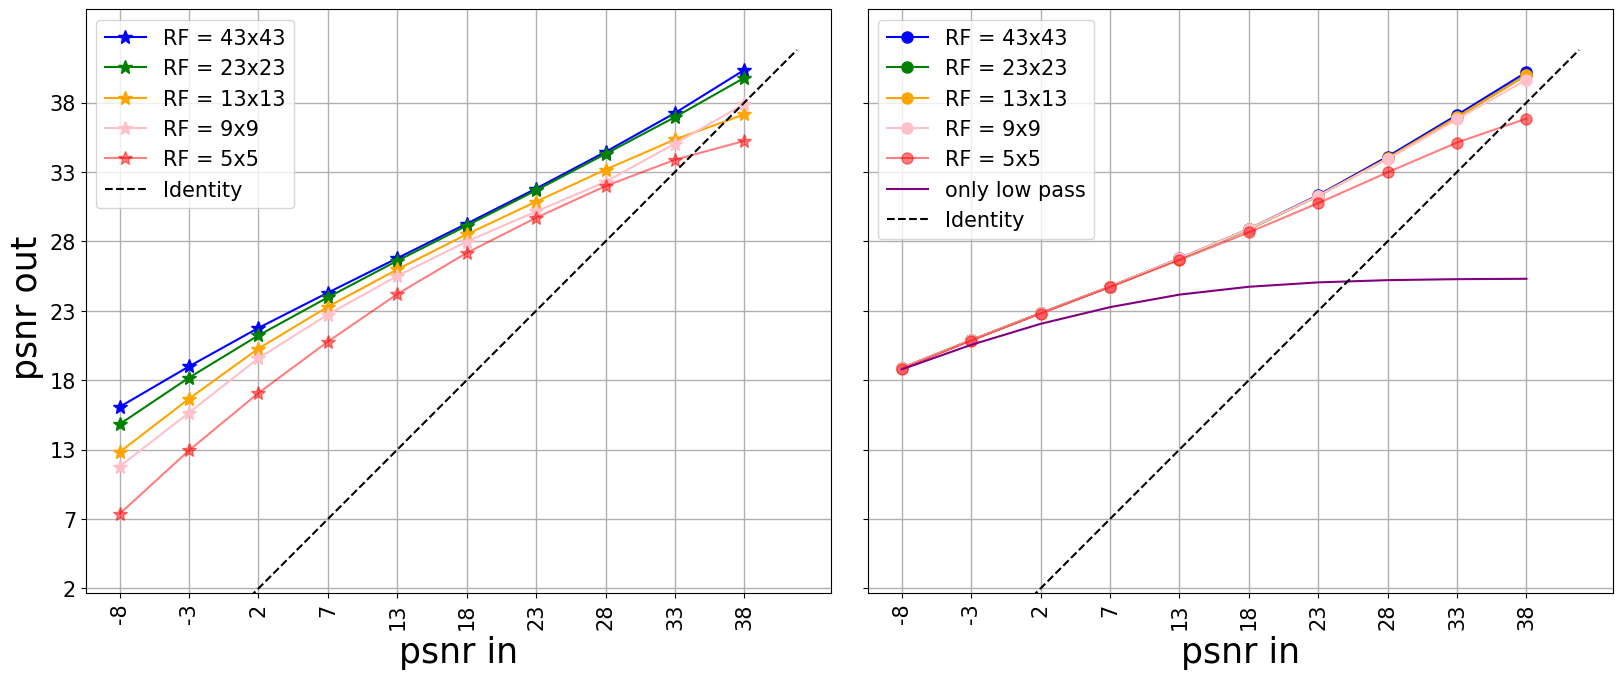

In [10]:
#### plot

f, axs = plt.subplots(1,2,figsize = (16,8), sharex=True,sharey=True)
f.tight_layout()
axs[0].set_aspect('equal', adjustable='box')
x_axis = [10*np.log10((255*1)**2/(sigma**2)) for sigma in flat_psnr_43.keys()]
axs[0].plot(x_axis, [flat_psnr_43[sigma] for sigma in flat_psnr_43.keys()],'-*',markersize = 10,color='blue', label = 'RF = 43x43')    
axs[0].plot(x_axis, [flat_psnr_23[sigma] for sigma in flat_psnr_23.keys()],'-*',markersize = 10,color='green',  label = 'RF = 23x23')    
axs[0].plot(x_axis, [flat_psnr_13[sigma] for sigma in flat_psnr_13.keys()],'-*',markersize = 10,color='orange', label = 'RF = 13x13')    
axs[0].plot(x_axis, [flat_psnr_9[sigma] for sigma in flat_psnr_9.keys()],'-*',markersize = 10,color='pink',label = 'RF = 9x9')    
axs[0].plot(x_axis, [flat_psnr_5[sigma] for sigma in flat_psnr_5.keys()],'-*',markersize = 10,color='red', alpha = .5,label = 'RF = 5x5')    

axs[0].plot([0,42], [0,42], '--', color='black' , label = 'Identity')
axs[0].legend(fontsize=15)
axs[0].grid(  linewidth=1);

axs[0].set_xticks(x_axis);
axs[0].set_yticks(x_axis);
axs[0].set_ylim(2,45)

axs[0].set_ylabel('psnr out ', fontsize = 25, fontname= 'DejaVu Sans');
axs[0].set_xlabel('psnr in', fontsize = 25, fontname= 'DejaVu Sans');
axs[0].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=5)
axs[0].set_yticklabels(np.round(x_axis).astype(int) , fontsize=5);
for tick in axs[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
    tick.label.set_fontname("DejaVu Sans")
for tick in axs[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
    tick.label.set_fontname("DejaVu Sans")
    
axs[1].set_aspect('equal', adjustable='box')

axs[1].plot(x_axis, [psnrs_43x43[sigma] for sigma in psnrs_43x43.keys()],'-o',color='blue', markersize = 8,label = 'RF = 43x43')    
axs[1].plot(x_axis, [psnrs_23x23[sigma] for sigma in psnrs_23x23.keys()],'-o',color='green', markersize = 8,label = 'RF = 23x23')    
axs[1].plot(x_axis, [psnrs_13x13[sigma] for sigma in psnrs_13x13.keys()],'-o',color='orange', markersize = 8,label = 'RF = 13x13')    
axs[1].plot(x_axis, [psnrs_9x9[sigma] for sigma in psnrs_9x9.keys()],'-o',color='pink', markersize = 8,label = 'RF = 9x9')    
axs[1].plot(x_axis, [psnrs_5x5[sigma] for sigma in psnrs_5x5.keys()],'-o',color='red', markersize = 8,label = 'RF = 5x5', alpha =.5)    
axs[1].plot(x_axis, [psnrs_id[sigma] for sigma in psnrs_id.keys()],'-',color='purple', markersize = 8,label = 'only low pass')    


axs[1].plot([0,42], [0,42], '--',color = 'black', label = 'Identity')
axs[1].legend(fontsize=15)
axs[1].grid(  linewidth=1);
axs[1].set_xticks(x_axis);
axs[1].set_yticks(x_axis);
axs[1].set_ylim(2,45)

# axs[1].set_ylabel('psnr out ', fontsize = 25, fontname= 'DejaVu Sans');
axs[1].set_xlabel('psnr in', fontsize = 25, fontname= 'DejaVu Sans');
axs[1].set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=15)
axs[1].set_yticklabels(np.round(x_axis).astype(int) , fontsize=15);
for tick in axs[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
    tick.label.set_fontname("DejaVu Sans")
for tick in axs[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
    tick.label.set_fontname("DejaVu Sans")
    
 




# local weighted averaging 

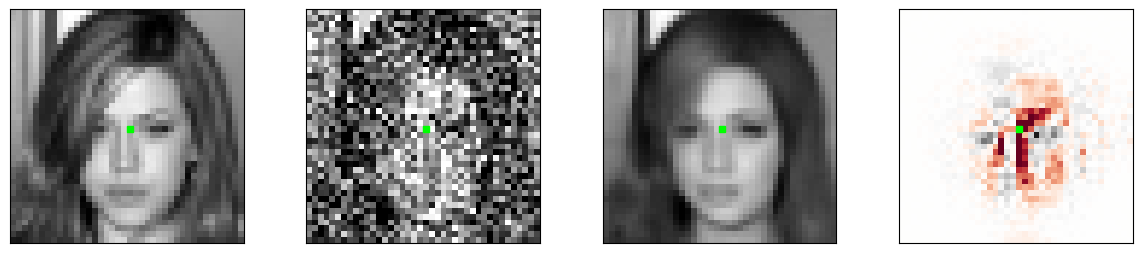

In [11]:
sigma =1
n = 87
clean = test_im[n:n+1]

noise = torch.randn_like(clean, device=device)*sigma
noisy = clean + noise

clean_down = multi_scale_decompose(clean, 2, device)[1][:,0:1]
noisy_down = multi_scale_decompose(noisy, 2, device)[1][:,0:1]


torch.manual_seed(0)  
#######
with torch.no_grad():
    denoised_low = noisy_down - denoisers_13x13['low'](noisy_down).detach()    

########    
i,j = 20,20

J_row = calc_jacobian_rows(noisy_down, denoisers_13x13['low'], 20,20)
J_row.shape
J_row[i,j] = 1 - J_row[i,j]    


### plot
f , axs = plt.subplots(1,4 , figsize=(12,3))
f.tight_layout()


fig = axs[0].imshow(clean_down.squeeze().cpu(), 'gray')
axs[0].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
pa = patches.Rectangle((i-.5,j-.5), width=1, height=1, angle=0.0, edgecolor = [0,1,0], facecolor=[0,1,0])
axs[0].add_patch(pa);

fig = axs[1].imshow(noisy_down.detach().squeeze().cpu(), 'gray', vmin=0, vmax = 1)
pa = patches.Rectangle((i-.5,j-.5), width=1, height=1, angle=0.0, edgecolor = [0,1,0], facecolor=[0,1,0])
axs[1].add_patch(pa)
axs[1].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)

fig = axs[2].imshow(denoised_low.detach().squeeze().cpu(), 'gray')
pa = patches.Rectangle((i-.5,j-.5), width=1, height=1, angle=0.0, edgecolor = [0,1,0], facecolor=[0,1,0])
axs[2].add_patch(pa)
axs[2].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)


limit =  max(torch.abs(torch.min( J_row)), torch.abs(torch.max( J_row)))/1
fig = axs[3].imshow(J_row.cpu()*2, 'RdGy', vmin = -limit, vmax = limit)
pa = patches.Rectangle((i-.5,j-.5), width=1, height=1, angle=0.0, edgecolor = [0,1,0], facecolor=[0,1,0])
axs[3].add_patch(pa)
axs[3].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
          




torch.Size([160, 160])


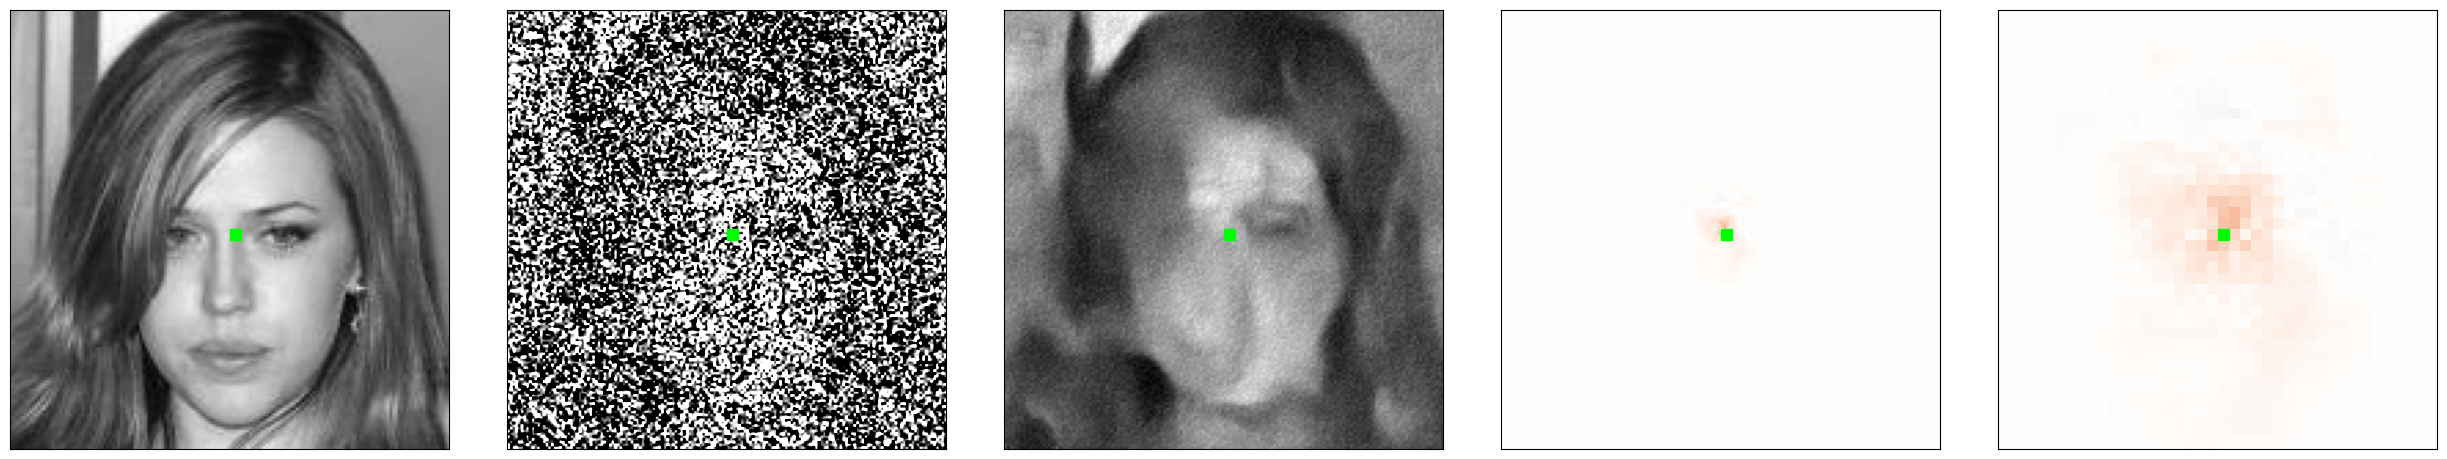

In [12]:
####### for large dnoiser 
with torch.no_grad():
    denoised = noisy - flat_denoiser_43x43(noisy).detach()    

#######    
i,j = 80,80

J_row = calc_jacobian_rows(noisy, flat_denoiser_43x43, i,j)
print(J_row.shape)
J_row[i,j] = 1 - J_row[i,j]

####plot
f , axs = plt.subplots(1,5 , figsize=(25,5))
f.tight_layout()


fig = axs[0].imshow(clean.squeeze().cpu(), 'gray')
axs[0].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
pa = patches.Rectangle((i-.5,j-.5), width=4, height=4, angle=0.0, edgecolor = [0,1,0], facecolor=[0,1,0])
axs[0].add_patch(pa);

fig = axs[1].imshow(noisy.detach().squeeze().cpu(), 'gray', vmin=0, vmax = 1)
pa = patches.Rectangle((i-.5,j-.5), width=4, height=4, angle=0.0, edgecolor = [0,1,0], facecolor=[0,1,0])
axs[1].add_patch(pa)
axs[1].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)

fig = axs[2].imshow(denoised.detach().squeeze().cpu(), 'gray')
pa = patches.Rectangle((i-.5,j-.5), width=4, height=4, angle=0.0, edgecolor = [0,1,0], facecolor=[0,1,0])
axs[2].add_patch(pa)
axs[2].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)


limit =  max(torch.abs(torch.min( J_row)), torch.abs(torch.max( J_row)))
fig = axs[3].imshow(J_row.cpu(), 'RdGy', vmin = -limit, vmax = limit)
pa = patches.Rectangle((i-.5,j-.5), width=4, height=4, angle=0.0, edgecolor = [0,1,0], facecolor=[0,1,0])
axs[3].add_patch(pa)
axs[3].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)

fig = axs[4].imshow(J_row.cpu()[60:100,60:100], 'RdGy', vmin = -limit, vmax = limit)
pa = patches.Rectangle((20-0.5,20-.5), width=1, height=1, angle=0.0, edgecolor = [0,1,0], facecolor=[0,1,0])
axs[4].add_patch(pa)
axs[4].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)


# plt.savefig('ICLR_figs/denoising/extreme_noise_large_im_sig1.pdf', bbox_inches='tight')    



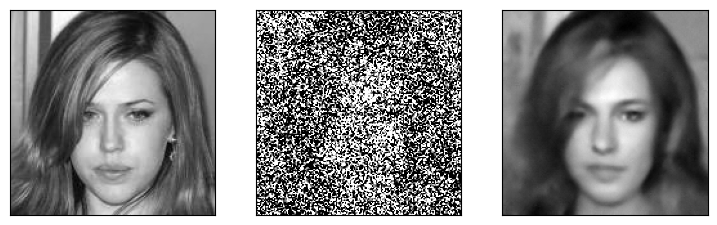

In [13]:
n = 87
clean = test_im[n:n+1]

torch.manual_seed(0)   

noise = torch.randn_like(clean, device=device)*sigma
noisy = clean + noise
denoised = multi_scale_denoising(noisy, denoisers_13x13,device=device, orth_forward=False)
denoised.reverse()
denoised = denoised[0]

f, axs = plt.subplots(1,3,figsize = (9,3))
fig=axs[0].imshow(clean.cpu().squeeze(), 'gray')
fig=axs[1].imshow(noisy.cpu().squeeze(), 'gray', vmin=0, vmax = 1) 
fig=axs[2].imshow(denoised.cpu().squeeze(), 'gray')

for i in range(3): 
    axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)

# Super resolution 

Start from a low resolution (40x40) image and increase its resolution by synthesizing details using the local conditional denoisers in a cascade. 

### Load denoiser 
Trained on 320x320 images

In [4]:
base_path= '/mnt/home/zkadkhodaie/ceph/multi_scale_synthesis/denoisers'
training_data_name='celebA_320x320_gray'
training_noise='noise_range_0to255'

denoisers_13x13 = load_multi_scale_denoisers_RF(base_path, training_data_name, training_noise, RF_low=40, RF=13, J=3)


In [5]:
print(denoisers_13x13.keys())
print(denoisers_13x13['low'].training )

dict_keys(['low', 0, 1, 2])
False


### Load images 

In [6]:
train_folder_path = '/mnt/home/zkadkhodaie/ceph/datasets/img_align_celeba_512x512/train/'
test_folder_path = '/mnt/home/zkadkhodaie/ceph/datasets/img_align_celeba_512x512/test/'
all_images= load_CelebA_HQ_dataset( train_folder_path, test_folder_path, s=.625, n=100)
train_im, test_im = prep_celeba(all_images, k=None, mean_zero=False)
test_im = test_im.to(device)
train_im = train_im.to(device)
test_im.shape


torch.Size([100, 1, 320, 320])

-------- torch.Size([1, 40, 40])
-------------------- scale:  2
-------- total number of iterations,  78
-------- average time per iteration (s),  0.0188
-------- final sigma,  0.0002591181546449661
-------- final mean  0.0001623437274247408
-------- final snr,  40.084428787231445
-------- torch.Size([1, 80, 80])
-------- im range:  0.02386345900595188 0.8421692848205566
-------------------- scale:  1
-------- total number of iterations,  98
-------- average time per iteration (s),  0.0033
-------- final sigma,  0.00017082958947867155
-------- final mean  1.9164631339663174e-06
-------- final snr,  40.10951042175293
-------- torch.Size([1, 160, 160])
-------- im range:  0.009974595159292221 0.9074627161026001
-------------------- scale:  0
-------- total number of iterations,  88
-------- average time per iteration (s),  0.0034
-------- final sigma,  0.00016303315351251513
-------- final mean  0.0001997200452024117
-------- final snr,  36.51966333389282
-------- torch.Size([1, 320, 320

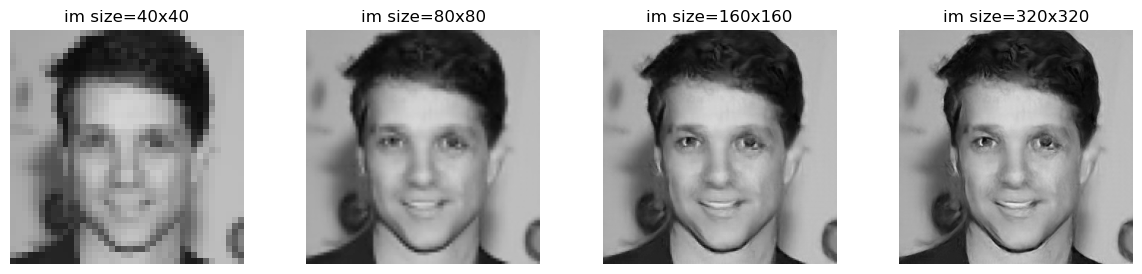

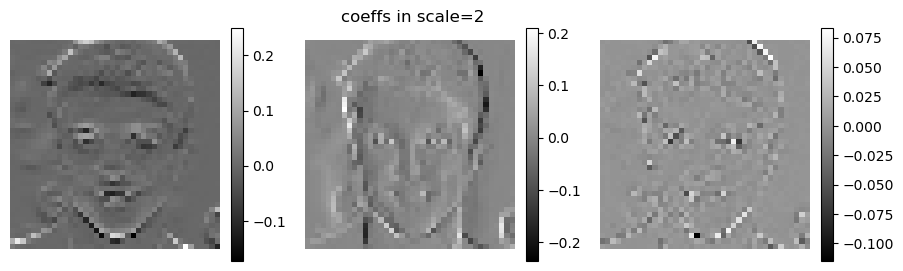

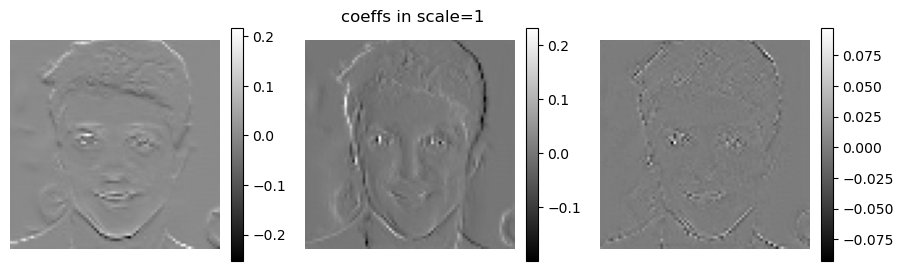

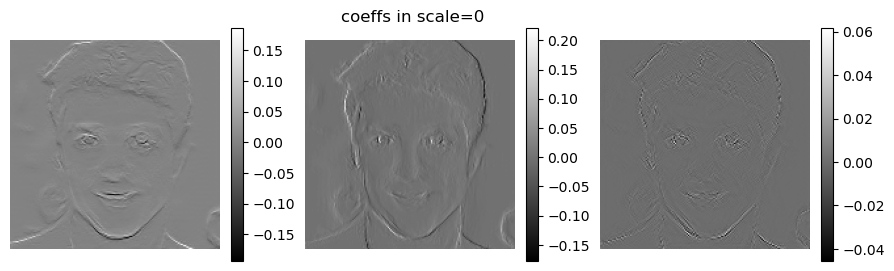

In [7]:
# pick a low resolution image from the test dataset
n = 0
clean_coeffs = multi_scale_decompose(test_im[n:n+1], J = 3, device=device)
low_res_im = clean_coeffs[2][:,0]
# synthesize
final_im, inter_im , coeffs= multi_scale_synthesis(models=denoisers_13x13, 
                                 init_im =low_res_im, 
                                 sig_0={'low':1, 2:1, 1:1, 0:1}, 
                                 sig_L={'low':.01,2:.01, 1:.01, 0:.015}, 
                                 h0={'low':.01 ,2:.01, 1:.01, 0:.01} ,
                                 beta={'low':.01,2:.5, 1:.5, 0:.5} , 
                                 freq={'low':0,2:0, 1:0, 0:0}, 
                                 device = device, 
                                 orth_forward=True,
                                 seeds = {'low':0, 2:0, 1:0, 0:0 },                                                
                                 fixed_h = {'low':True, 2:False, 1:False, 0:False })
#plot                                    
f, axs = plt.subplots(1,4, figsize = (12,3))
plt.tight_layout()
for j in range(4): 
    fig=axs[j].imshow(final_im[j].cpu().squeeze(), 'gray', vmin=0, vmax = 1)
    axs[j].axis('off')
    s = final_im[j].cpu().squeeze().shape[0]
    axs[j].set_title('im size='+str(s)+'x'+str(s) )
for j in range(1,4): 
    f, axs = plt.subplots(1,3, figsize = (9,3))
    plt.tight_layout()
    f.suptitle('coeffs in scale='+ str(3-j))
    for o in range(3): 
        fig=axs[o].imshow(coeffs[j][o].cpu().squeeze(), 'gray')
        plt.colorbar(fig, ax=axs[o], fraction=.05)
        axs[o].axis('off')

-------- torch.Size([1, 40, 40])
-------------------- scale:  2
-------- total number of iterations,  144
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.0001645531301619485
-------- final mean  -0.0005386419361457229
-------- final snr,  40.06141662597656
-------- torch.Size([1, 80, 80])
-------- im range:  0.022595703601837158 0.7945631742477417
-------------------- scale:  1
-------- total number of iterations,  161
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.00011218041618121788
-------- final mean  -0.0003054408880416304
-------- final snr,  40.01707077026367
-------- torch.Size([1, 160, 160])
-------- im range:  0.010156506672501564 0.8351963758468628
-------------------- scale:  0
-------- total number of iterations,  162
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.00010107794514624402
-------- final mean  2.6305253413738683e-05
-------- final snr,  36.493847370147705
-------- torch.Size([1, 32

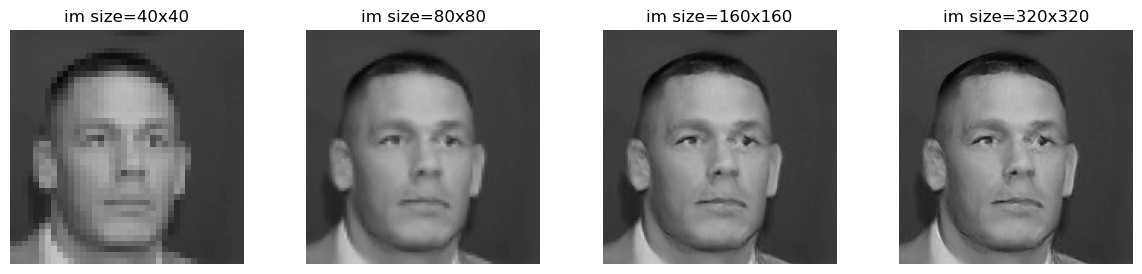

In [107]:
n = 10
clean_coeffs = multi_scale_decompose(test_im[n:n+1], J = 3, device=device)
low_res_im = clean_coeffs[2][:,0]
final_im, inter_im , coeffs= multi_scale_synthesis(denoisers_13x13, 
                                 low_res_im, 
                                 sig_0={'low':1, 2:1, 1:1, 0:1}, 
                                 sig_L={'low':.01,2:.01, 1:.01, 0:.015}, 
                                 h0={'low':.01 ,2:.01, 1:.01, 0:.01} ,
                                 beta={'low':.01,2:.1, 1:.1, 0:.1} , 
                                 freq={'low':0,2:0, 1:0, 0:0}, 
                                 device = device, 
                                 orth_forward=True,
                                 seeds = {'low':None, 2:0, 1:0, 0:0 },
                                 fixed_h = {'low':True, 2:False, 1:False, 0:False })
                                                
                                    
f, axs = plt.subplots(1,4, figsize = (12,3))
plt.tight_layout()
for j in range(4): 
    fig=axs[j].imshow(final_im[j].cpu().squeeze(), 'gray', vmin=0,vmax = 1)
    axs[j].axis('off')
    s = final_im[j].cpu().squeeze().shape[0]
    axs[j].set_title('im size='+str(s)+'x'+str(s) )


-------- torch.Size([1, 40, 40])
-------------------- scale:  2
-------- total number of iterations,  133
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.00022517792240250856
-------- final mean  6.865608156658709e-05
-------- final snr,  40.033226013183594
-------- torch.Size([1, 80, 80])
-------- im range:  0.02367532067000866 0.8389886617660522
-------------------- scale:  1
-------- total number of iterations,  154
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.00015237256593536586
-------- final mean  -7.319388532778248e-05
-------- final snr,  40.147361755371094
-------- torch.Size([1, 160, 160])
-------- im range:  -0.001729816198348999 0.8483121991157532
-------------------- scale:  0
-------- total number of iterations,  157
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.0001486121618654579
-------- final mean  0.0001486770051997155
-------- final snr,  36.478610038757324
-------- torch.Size([1, 32

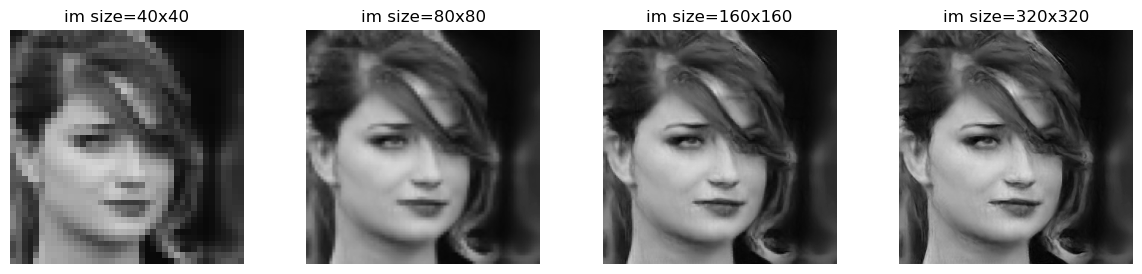

In [110]:
n = 2
clean_coeffs = multi_scale_decompose(test_im[n:n+1], J = 3, device=device)
low_res_im = clean_coeffs[2][:,0]
 
final_im, inter_im , coeffs= multi_scale_synthesis(denoisers_13x13, 
                                 low_res_im, 
                                 sig_0={'low':1, 2:1, 1:1, 0:1}, 
                                 sig_L={'low':.01,2:.01, 1:.01, 0:.015}, 
                                 h0={'low':.01 ,2:.01, 1:.01, 0:.01} ,
                                 beta={'low':.01,2:.1, 1:.1, 0:.1} , 
                                 freq={'low':0,2:0, 1:0, 0:0}, 
                                 device = device, 
                                 orth_forward=True,
                                 seeds = {'low':0, 2:0, 1:0, 0:0 },
                                 fixed_h = {'low':True, 2:False, 1:False, 0:False })
                                                   
                                    
f, axs = plt.subplots(1,4, figsize = (12,3))
plt.tight_layout()
for j in range(4): 
    fig=axs[j].imshow(final_im[j].cpu().squeeze(), 'gray', vmin=0, vmax = 1)
    axs[j].axis('off')
    s = final_im[j].cpu().squeeze().shape[0]
    axs[j].set_title('im size='+str(s)+'x'+str(s) )


-------- torch.Size([1, 40, 40])
-------------------- scale:  2
-------- total number of iterations,  85
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.0002310430136276409
-------- final mean  -0.0007183033740147948
-------- final snr,  40.03838539123535
-------- torch.Size([1, 80, 80])
-------- im range:  -0.002184671349823475 0.8232144117355347
-------------------- scale:  1
-------- total number of iterations,  106
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.000157241738634184
-------- final mean  -0.0005802345112897456
-------- final snr,  40.11137008666992
-------- torch.Size([1, 160, 160])
-------- im range:  -0.012612656690180302 0.8348015546798706
-------------------- scale:  0
-------- total number of iterations,  89
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.00015045407053548843
-------- final mean  -1.5587955203955062e-05
-------- final snr,  36.50768518447876
-------- torch.Size([1, 320,

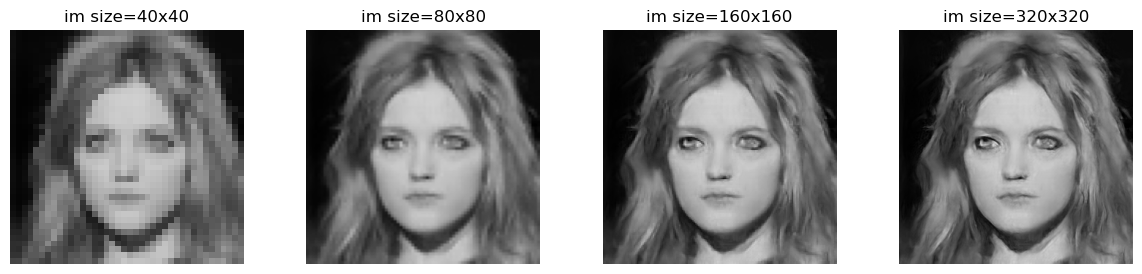

In [39]:
n = 5
clean_coeffs = multi_scale_decompose(test_im[n:n+1], J = 3, device=device)
low_res_im = clean_coeffs[2][:,0]
final_im, inter_im , coeffs= multi_scale_synthesis(denoisers_13x13, 
                                 low_res_im, 
                                 sig_0={'low':1, 2:1, 1:1, 0:1}, 
                                 sig_L={'low':.01,2:.01, 1:.01, 0:.015}, 
                                 h0={'low':.01 ,2:.01, 1:.01, 0:.01} ,
                                 beta={'low':.01,2:.5, 1:.5, 0:.5} , 
                                 freq={'low':0,2:0, 1:0, 0:0}, 
                                 device = device, 
                                 orth_forward=True,
                                 seeds = {'low':0, 2:0, 1:0, 0:0 },
                                 fixed_h = {'low':True, 2:False, 1:False, 0:False })
                                                   
                                    
f, axs = plt.subplots(1,4, figsize = (12,3))
plt.tight_layout()
for j in range(4): 
    fig=axs[j].imshow(final_im[j].cpu().squeeze(), 'gray', vmin=0,vmax = 1)
    axs[j].axis('off')
    s = final_im[j].cpu().squeeze().shape[0]
    axs[j].set_title('im size='+str(s)+'x'+str(s) )


# Syntehsis
Generating low-pass rather than using a low-resolution image. We will use the denoiser trained on low pass coefficients which embeds an implicit global prior of the low pass images. To capture this global prior perfectly to generate higher quality low pass images a larger and higher complexity model is needed. Here we show random examples which contain artifacts 

-------------------- generating low pass image
-------- total number of iterations,  10483
-------- average time per iteration (s),  0.0039
-------- final sigma,  0.009118142537772655
-------- final mean  0.06151707470417023
-------- final snr,  12.068747282028198
-------- im range:  0.007477731443941593 0.128864124417305
-------- torch.Size([1, 40, 40])
-------------------- scale:  2
-------- total number of iterations,  65
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.00021138592273928225
-------- final mean  -0.00037443990004248917
-------- final snr,  40.03063678741455
-------- torch.Size([1, 80, 80])
-------- im range:  -0.03621915355324745 0.8059231042861938
-------------------- scale:  1
-------- total number of iterations,  85
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.00012317378423176706
-------- final mean  -0.0003406702890060842
-------- final snr,  40.16043663024902
-------- torch.Size([1, 160, 160])
-------- im ra

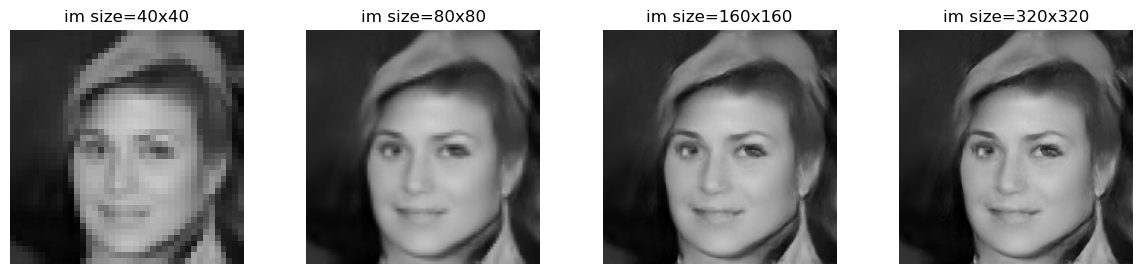

In [121]:
   
final_im, inter_im , coeffs= multi_scale_synthesis(denoisers_13x13, 
                                 (1,40,40), #rather than a low-res image, give the size of the low-res to be generated 
                                 sig_0={'low':1, 2:1, 1:1, 0:1}, 
                                 sig_L={'low':.25,2:.01, 1:.01, 0:.01}, 
                                 h0={'low':.01 ,2:.01, 1:.01, 0:.01} ,
                                 beta={'low':.01,2:1, 1:1, 0:1} , 
                                 freq={'low':0,2:0, 1:0, 0:0}, 
                                 device = device, 
                                 orth_forward=True,
                                 seeds = {'low':3, 2:0, 1:0, 0:0 },
                                 fixed_h = {'low':True, 2:False, 1:False, 0:False })

#plot                                    
f, axs = plt.subplots(1,4, figsize = (12,3))
plt.tight_layout()
for j in range(4): 
    fig=axs[j].imshow(final_im[j].cpu().squeeze(), 'gray', vmin=0, vmax = 1)
    axs[j].axis('off')
    s = final_im[j].cpu().squeeze().shape[0]
    axs[j].set_title('im size='+str(s)+'x'+str(s) )


-------------------- generating low pass image
-------- total number of iterations,  14208
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.004421338438987732
-------- final mean  0.037892960011959076
-------- final snr,  14.004155397415161
-------- im range:  0.0015185107477009296 0.0725724920630455
-------- torch.Size([1, 40, 40])
-------------------- scale:  2
-------- total number of iterations,  60
-------- average time per iteration (s),  0.0036
-------- final sigma,  0.00020839602802880108
-------- final mean  0.0015911213122308254
-------- final snr,  40.102972984313965
-------- torch.Size([1, 80, 80])
-------- im range:  -0.025586210191249847 0.8029367923736572
-------------------- scale:  1
-------- total number of iterations,  80
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.000129582331283018
-------- final mean  0.0006648701382800937
-------- final snr,  40.06495475769043
-------- torch.Size([1, 160, 160])
-------- im ra

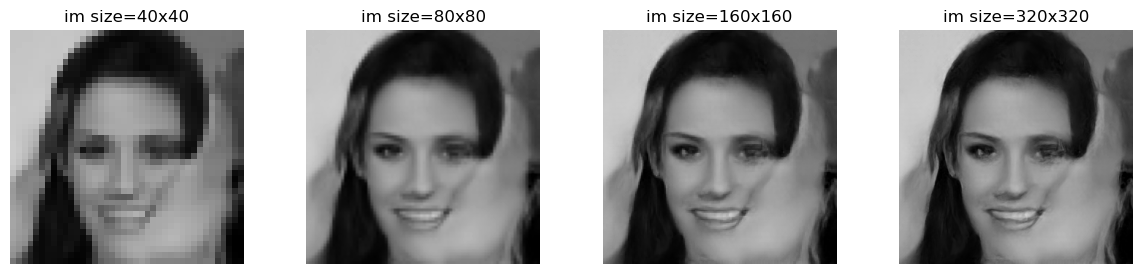

In [24]:
   
final_im, inter_im , coeffs= multi_scale_synthesis(denoisers_13x13, 
                                 (1,40,40), #rather than a low-res image, give the size of the low-res to be generated 
                                 sig_0={'low':1, 2:1, 1:1, 0:1}, 
                                 sig_L={'low':.2,2:.01, 1:.01, 0:.015}, 
                                 h0={'low':.01 ,2:.01, 1:.01, 0:.01} ,
                                 beta={'low':.01,2:1, 1:1, 0:1} , 
                                 freq={'low':0,2:0, 1:0, 0:0}, 
                                 device = device, 
                                 orth_forward=True,
                                 seeds = {'low':10, 2:0, 1:0, 0:0 },
                                 fixed_h = {'low':True, 2:False, 1:False, 0:False })

#plot                                    
f, axs = plt.subplots(1,4, figsize = (12,3))
plt.tight_layout()
for j in range(4): 
    fig=axs[j].imshow(final_im[j].cpu().squeeze(), 'gray', vmin=0, vmax = 1)
    axs[j].axis('off')
    s = final_im[j].cpu().squeeze().shape[0]
    axs[j].set_title('im size='+str(s)+'x'+str(s) )

-------------------- generating low pass image
-------- total number of iterations,  5359
-------- average time per iteration (s),  0.0039
-------- final sigma,  0.027958163991570473
-------- final mean  0.40802791714668274
-------- final snr,  20.01662015914917
-------- im range:  0.011606397107243538 1.4066252708435059
-------- torch.Size([1, 40, 40])
-------------------- scale:  2
-------- total number of iterations,  71
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.0001322988682659343
-------- final mean  -0.0009484138572588563
-------- final snr,  40.00570297241211
-------- torch.Size([1, 80, 80])
-------- im range:  -0.008447816595435143 0.8058348298072815
-------------------- scale:  1
-------- total number of iterations,  90
-------- average time per iteration (s),  0.0038
-------- final sigma,  8.199936564778909e-05
-------- final mean  -0.0005398913635872304
-------- final snr,  40.14669418334961
-------- torch.Size([1, 160, 160])
-------- im range

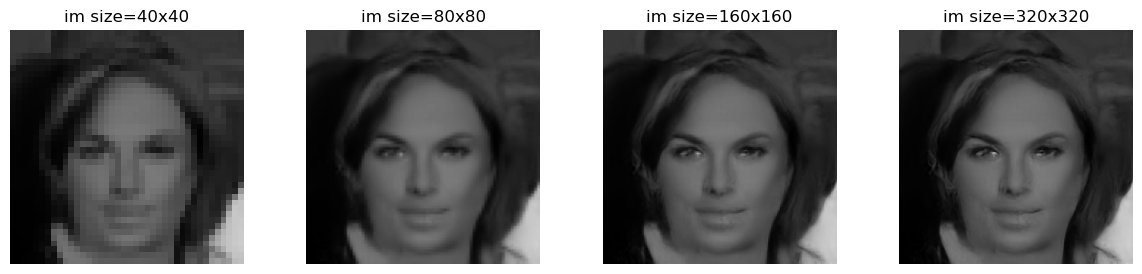

In [14]:
  
final_im, inter_im , coeffs= multi_scale_synthesis(denoisers_13x13, 
                                 (1,40,40), #rather than a low-res image, give the size of the low-res to be generated 
                                 sig_0={'low':1, 2:1, 1:1, 0:1}, 
                                 sig_L={'low':.1,2:.01, 1:.01, 0:.015}, 
                                 h0={'low':.01 ,2:.01, 1:.01, 0:.01} ,
                                 beta={'low':.01,2:1, 1:1, 0:1} , 
                                 freq={'low':0,2:0, 1:0, 0:0}, 
                                 device = device, 
                                 orth_forward=True,
                                 seeds = {'low':None, 2:None, 1:None, 0:None },
                                 fixed_h = {'low':True, 2:False, 1:False, 0:False })


#plot                                    
f, axs = plt.subplots(1,4, figsize = (12,3))
plt.tight_layout()
for j in range(4): 
    fig=axs[j].imshow(final_im[j].cpu().squeeze(), 'gray', vmin=0, vmax = 1)
    axs[j].axis('off')
    s = final_im[j].cpu().squeeze().shape[0]
    axs[j].set_title('im size='+str(s)+'x'+str(s) )

-------------------- generating low pass image
-------- total number of iterations,  10675
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.0027761596720665693
-------- final mean  0.04003334417939186
-------- final snr,  20.008909702301025
-------- im range:  0.0009495504200458527 0.09307427704334259
-------- torch.Size([1, 40, 40])
-------------------- scale:  2
-------- total number of iterations,  73
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.00022392386745195836
-------- final mean  -0.0008273805724456906
-------- final snr,  40.07369518280029
-------- torch.Size([1, 80, 80])
-------- im range:  -0.03207947686314583 0.86729896068573
-------------------- scale:  1
-------- total number of iterations,  92
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.0001377299049636349
-------- final mean  -0.0007552446331828833
-------- final snr,  40.086421966552734
-------- torch.Size([1, 160, 160])
-------- im r

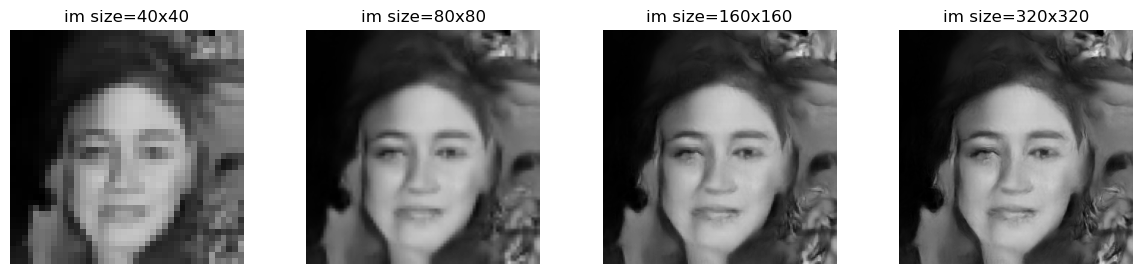

In [23]:
  
final_im, inter_im , coeffs= multi_scale_synthesis(denoisers_13x13, 
                                 (1,40,40), #rather than a low-res image, give the size of the low-res to be generated 
                                 sig_0={'low':1, 2:1, 1:1, 0:1}, 
                                 sig_L={'low':.1,2:.01, 1:.01, 0:.015}, 
                                 h0={'low':.01 ,2:.01, 1:.01, 0:.01} ,
                                 beta={'low':.01,2:1, 1:1, 0:1} , 
                                 freq={'low':0,2:0, 1:0, 0:0}, 
                                 device = device, 
                                 orth_forward=True,
                                 seeds = {'low':None, 2:None, 1:None, 0:None },
                                 fixed_h = {'low':True, 2:False, 1:False, 0:False })


#plot                                    
f, axs = plt.subplots(1,4, figsize = (12,3))
plt.tight_layout()
for j in range(4): 
    fig=axs[j].imshow(final_im[j].cpu().squeeze(), 'gray', vmin=0, vmax = 1)
    axs[j].axis('off')
    s = final_im[j].cpu().squeeze().shape[0]
    axs[j].set_title('im size='+str(s)+'x'+str(s) )

-------------------- generating low pass image
-------- total number of iterations,  7507
-------- average time per iteration (s),  0.0039
-------- final sigma,  0.0050011323764920235
-------- final mean  0.12155578285455704
-------- final snr,  26.09539270401001
-------- im range:  -0.009281231090426445 0.32030531764030457
-------- torch.Size([1, 40, 40])
-------------------- scale:  2
-------- total number of iterations,  75
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.00024366674188058823
-------- final mean  -0.00035263056633993983
-------- final snr,  40.069780349731445
-------- torch.Size([1, 80, 80])
-------- im range:  -0.039074670523405075 0.9120810627937317
-------------------- scale:  1
-------- total number of iterations,  96
-------- average time per iteration (s),  0.0037
-------- final sigma,  0.00016169945592992008
-------- final mean  -0.00047095934860408306
-------- final snr,  40.00424385070801
-------- torch.Size([1, 160, 160])
-------- 

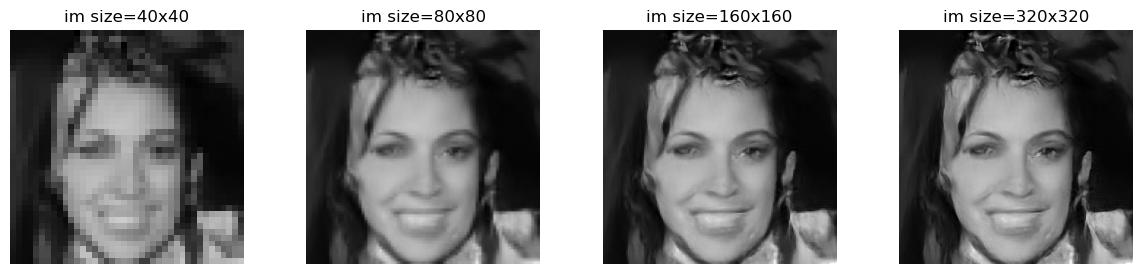

In [28]:
  
final_im, inter_im , coeffs= multi_scale_synthesis(denoisers_13x13, 
                                 (1,40,40), #rather than a low-res image, give the size of the low-res to be generated 
                                 sig_0={'low':1, 2:1, 1:1, 0:1}, 
                                 sig_L={'low':.05,2:.01, 1:.01, 0:.015}, 
                                 h0={'low':.01 ,2:.01, 1:.01, 0:.01} ,
                                 beta={'low':.01,2:1, 1:1, 0:1} , 
                                 freq={'low':0,2:0, 1:0, 0:0}, 
                                 device = device, 
                                 orth_forward=True,
                                 seeds = {'low':None, 2:None, 1:None, 0:None },
                                 fixed_h = {'low':True, 2:False, 1:False, 0:False })


#plot                                    
f, axs = plt.subplots(1,4, figsize = (12,3))
plt.tight_layout()
for j in range(4): 
    fig=axs[j].imshow(final_im[j].cpu().squeeze(), 'gray', vmin=0, vmax = 1)
    axs[j].axis('off')
    s = final_im[j].cpu().squeeze().shape[0]
    axs[j].set_title('im size='+str(s)+'x'+str(s) )

-------- total number of iterations,  123
-------- average time per iteration (s),  0.0041
-------- final sigma,  0.0004933821619488299
-------- final mean  0.10955062508583069
-------- final snr,  40.064101219177246
-------- total number of iterations,  124
-------- average time per iteration (s),  0.0041
-------- final sigma,  0.000421858683694154
-------- final mean  0.0828627496957779
-------- final snr,  40.23588180541992
-------- total number of iterations,  124
-------- average time per iteration (s),  0.0041
-------- final sigma,  0.0005272813723422587
-------- final mean  0.10847705602645874
-------- final snr,  40.091962814331055
-------- total number of iterations,  120
-------- average time per iteration (s),  0.0041
-------- final sigma,  0.0005905457073822618
-------- final mean  0.11378288269042969
-------- final snr,  40.06537914276123


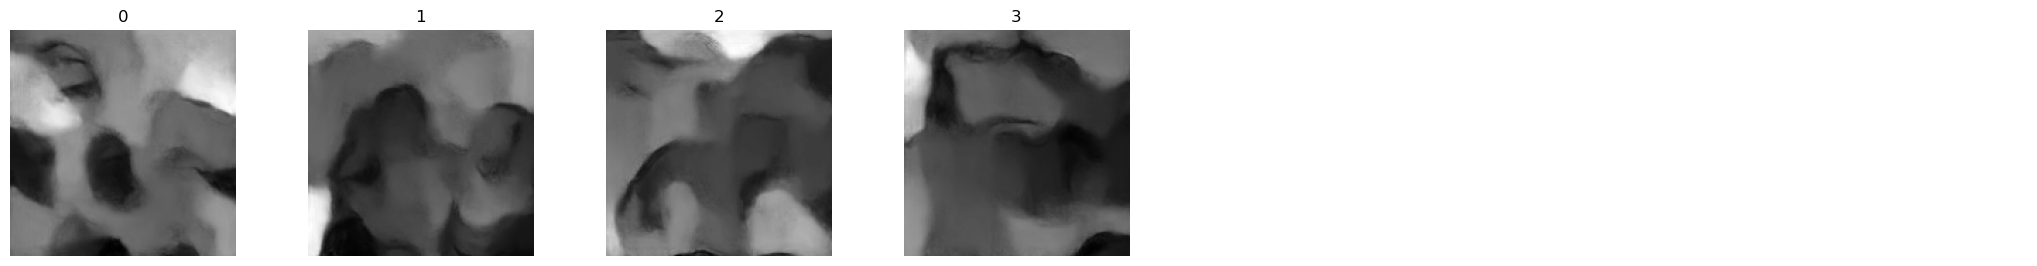

In [55]:
### generate 160x160 image using the flat denoiser trained on 160x160 face images 
final_ims = []
for i in range(4): 
    final_im, _,_,_ = one_scale_synthesis(flat_denoiser_43x43, 
                                     (1,160,160),
                                     sig_0=1, 
                                     sig_L=.01, 
                                     h0=.01,
                                     beta=.1 , 
                                     freq=0, 
                                     device = device, 
                                     fixed_h = False)
    final_ims.append(final_im.detach().cpu().squeeze())

show_im_set(torch.stack(final_ims), label='')

-------- total number of iterations,  3762
-------- average time per iteration (s),  0.0041
-------- final sigma,  0.0006749450694769621
-------- final mean  0.10123647749423981
-------- final snr,  40.00046730041504
-------- total number of iterations,  3791
-------- average time per iteration (s),  0.0041
-------- final sigma,  0.0006253213505260646
-------- final mean  0.10606363415718079
-------- final snr,  40.00204086303711
-------- total number of iterations,  3697
-------- average time per iteration (s),  0.0041
-------- final sigma,  0.0007180598331615329
-------- final mean  0.10856308043003082
-------- final snr,  40.00160217285156
-------- total number of iterations,  4103
-------- average time per iteration (s),  0.0041
-------- final sigma,  0.000528058735653758
-------- final mean  0.0731036439538002
-------- final snr,  40.02729892730713


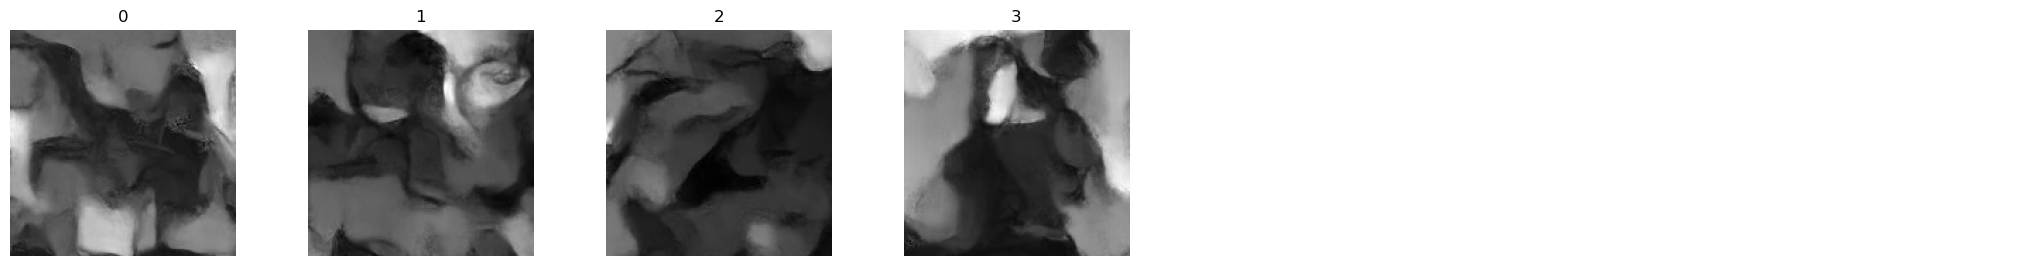

In [56]:
### generate 160x160 image using the flat denoiser trained on 160x160 face images 
final_ims = []
for i in range(4): 
    final_im, _,_,_ = one_scale_synthesis(flat_denoiser_43x43, 
                                     (1,160,160),
                                     sig_0=1, 
                                     sig_L=.01, 
                                     h0=.01,
                                     beta=.1 , 
                                     freq=0, 
                                     device = device, 
                                     fixed_h = True)
    final_ims.append(final_im.detach().cpu().squeeze())

show_im_set(torch.stack(final_ims), label='')

-------- total number of iterations,  100
-------- average time per iteration (s),  0.0039
-------- final sigma,  0.0011691710678860545
-------- final mean  0.18034477531909943
-------- final snr,  40.4704475402832
-------- total number of iterations,  101
-------- average time per iteration (s),  0.0039
-------- final sigma,  0.0012091546086594462
-------- final mean  0.17074844241142273
-------- final snr,  40.62448978424072
-------- total number of iterations,  105
-------- average time per iteration (s),  0.0039
-------- final sigma,  0.0009648010018281639
-------- final mean  0.15273573994636536
-------- final snr,  41.13162040710449
-------- total number of iterations,  98
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.0014956278027966619
-------- final mean  0.20090042054653168
-------- final snr,  40.4329776763916


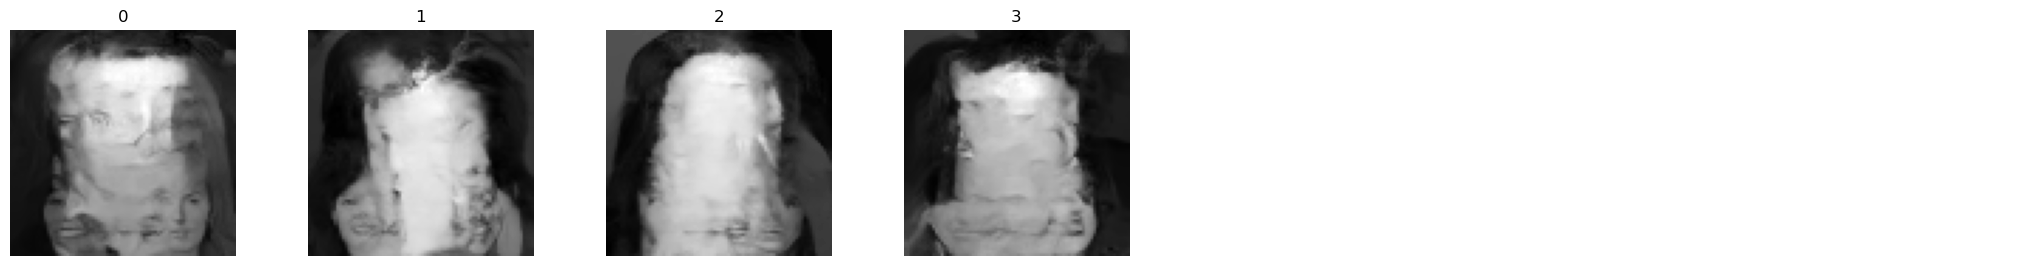

In [68]:
### generate 80x80 image using the flat denoiser trained on 40x40 face images 
final_ims = []
for i in range(4): 
    final_im, _,_,_ = one_scale_synthesis(denoisers_43x43['low'], 
                                     (1,80,80),
                                     sig_0=1, 
                                     sig_L=.01, 
                                     h0=.01,
                                     beta=.1 , 
                                     freq=0, 
                                     device = device, 
                                     fixed_h = False)
    final_ims.append(final_im.detach().cpu().squeeze())

show_im_set(torch.stack(final_ims), label='', im_size = 3 )

-------- total number of iterations,  3071
-------- average time per iteration (s),  0.0039
-------- final sigma,  0.0010643114801496267
-------- final mean  0.13445653021335602
-------- final snr,  40.05342483520508
-------- total number of iterations,  2952
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.001192662282846868
-------- final mean  0.16344448924064636
-------- final snr,  40.02075672149658
-------- total number of iterations,  2949
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.0009333512862212956
-------- final mean  0.17288215458393097
-------- final snr,  40.073304176330566
-------- total number of iterations,  3653
-------- average time per iteration (s),  0.0038
-------- final sigma,  0.0004935580072924495
-------- final mean  0.08428247272968292
-------- final snr,  40.027832984924316


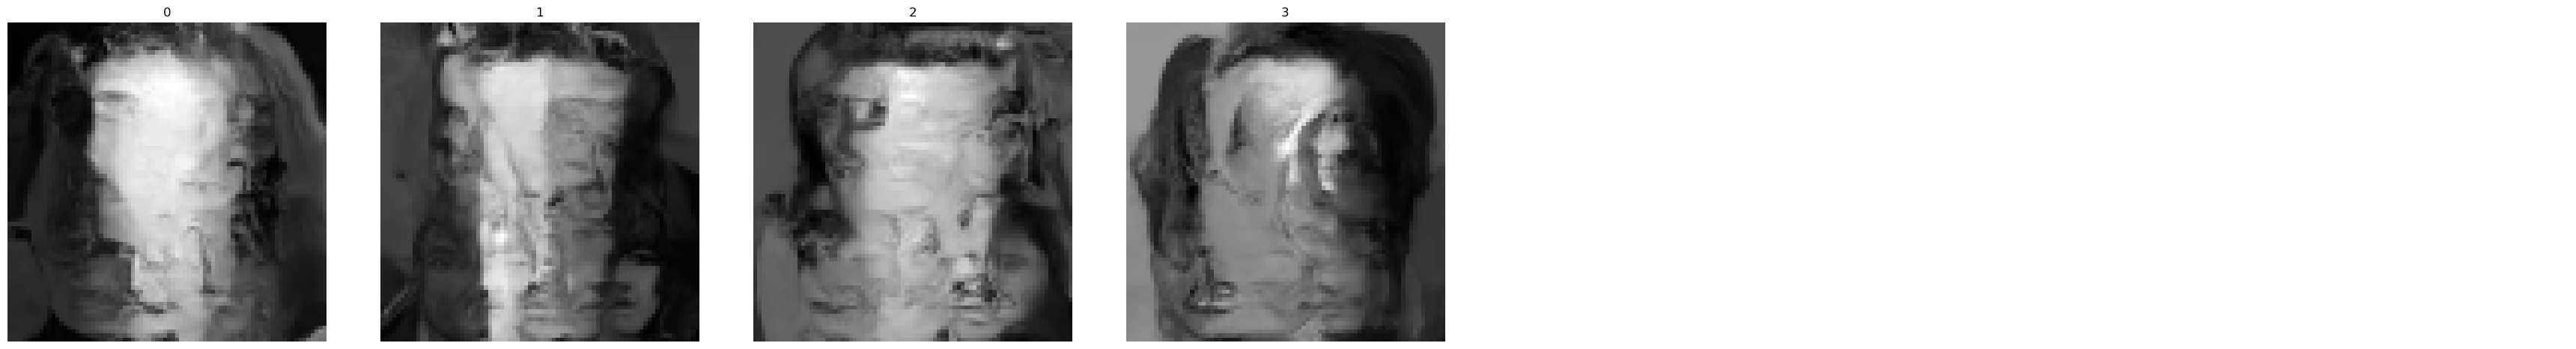

In [74]:
### generate 80x80 image using the flat denoiser trained on 40x40 face images 
final_ims = []
for i in range(4): 
    final_im, _,_,_ = one_scale_synthesis(denoisers_43x43['low'], 
                                     (1,80,80),
                                     sig_0=1, 
                                     sig_L=.01, 
                                     h0=.01,
                                     beta=.1 , 
                                     freq=0, 
                                     device = device, 
                                     fixed_h = True)
    final_ims.append(final_im.detach().cpu().squeeze())

show_im_set(torch.stack(final_ims), label='', im_size = 5 )